# Prior estimation

In [1]:
#include("../src/ObjectiveEmpiricalBayes.jl")
using Revise
using ObjectiveEmpiricalBayes
import ObjectiveEmpiricalBayes: OptConfig, Transformation, FEModel, generatedata, transformmodel, 
    ReferenceRegularizer, ThikonovRegularizer, cvscore, ebprior, compareplot

using Random: seed!
linspace(x...) = LinRange(x...) |> collect

OPTCONFIG=OptConfig(XTOLABS=1e-8, DEBUG=true);


┌ Info: Precompiling ObjectiveEmpiricalBayes [c9f68547-bb38-4662-99af-2e1b295e5967]
└ @ Base loading.jl:1273


In [2]:
using PyCall, PyPlot
# enable pyplot-latex
PyCall.PyDict(PyPlot.matplotlib["rcParams"])["text.usetex"] = true

ArgumentError: ArgumentError: Package PyCall not found in current path:
- Run `import Pkg; Pkg.add("PyCall")` to install the PyCall package.


## The Model

In [3]:
using Distributions

# exponential
xlims = (0,4)
n = 200 # was 500
ndata = 100
σ = 0.3
#prior = MixtureModel([truncated(Normal(mu, .5), xlims...) for mu in [1, 3]])
prior = truncated(MixtureModel([Normal(mu, .5) for mu in [1, 3]]), xlims...)


t    = Transformation(x->exp(x), x->log(x))

Transformation(var"#5#7"(), var"#6#8"())

In [4]:
# hotfix for error in rand truncated mixturemodel
# luckily it reconstructs the old behaviour so we can reuse the random seed
# c.f. https://github.com/JuliaStats/Distributions.jl/issues/1102

import Distributions.rand
function rand(d::Truncated{MixtureModel{Univariate,Continuous,Normal{Float64},Float64},Continuous,Float64}, n::Int64)
    xs = zeros(n)
    i = 1
    while i < n+1
        x = rand(d.untruncated)
        if x > d.lower && x < d.upper
            xs[i] = x
            i+=1
        end
    end
    xs
end

#function rand(d::Truncated{MixtureModel{Univariate,Continuous,Normal{Float64},Float64},Continuous,Float64}, n::Int64)
#    m = MixtureModel([truncated(n, d.lower, d.upper) for n in d.untruncated.components], d.untruncated.prior)
#    rand(m,n)
#end

rand (generic function with 183 methods)

In [5]:
randseed=90
seed!(randseed)
#srand(2)
m = FEModel(f=x->x, xs=linspace(xlims...,n), σ=σ)
d = generatedata(m, prior, ndata);

mt   = transformmodel(m, t)
d[1]

1.9175532528361363

In [6]:
ncv = 20
kfold = length(d);

In [7]:
lims = ([0,4],[0,.6],[1,55], [0,.2])

([0, 4], [0.0, 0.6], [1, 55], [0.0, 0.2])

## Results

In [8]:
scale = 1.1
figsize=(4,3).*scale

(4.4, 3.3000000000000003)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


 29

.841133 seconds (136.34 M allocations: 158.492 GiB, 12.32% gc time)
regR = (regs[argmax(ss)]).γ = 

┌ Warning: /home/axsk/.julia/packages/Plots/KVYUB/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /home/axsk/.julia/packages/Revise/C272c/src/Revise.jl:491


0.19473684210526315


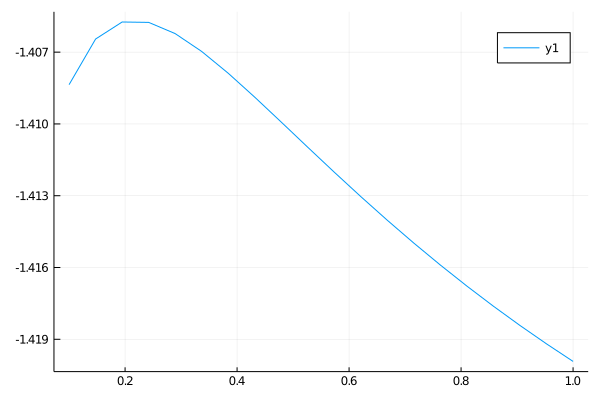

In [9]:
using Plots
## er estimator
regs = [ReferenceRegularizer(m, γ) for γ in linspace(0.1,1,ncv)]
@time ss = [cvscore(m, d, d->ebprior(m, d, r, OPTCONFIG), kfold) for r in regs]

@show regR = regs[argmax(ss)].γ
Plots.plot([r.γ for r in regs], ss)

 37.199279 seconds (132.24 M allocations: 207.655 GiB, 16.03% gc time)
regRt = (regs[argmax(ss)]).γ = 0.19473684210526315


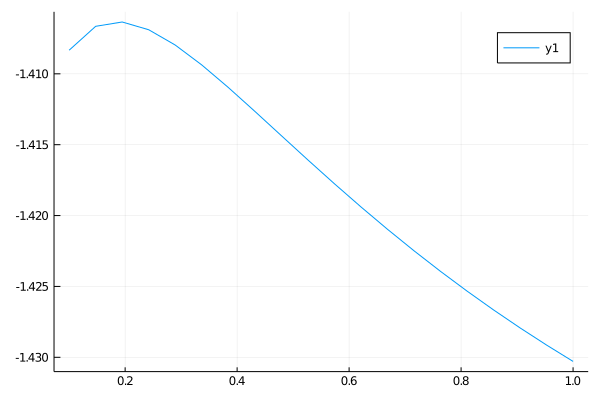

In [10]:
## er estimator transformed
regs = [ReferenceRegularizer(mt, γ) for γ in linspace(0.1,1,ncv)]
@time ss = [cvscore(mt, d, d->ebprior(mt, d, r, OPTCONFIG), kfold) for r in regs]

@show regRt = regs[argmax(ss)].γ
Plots.plot([r.γ for r in regs], ss)

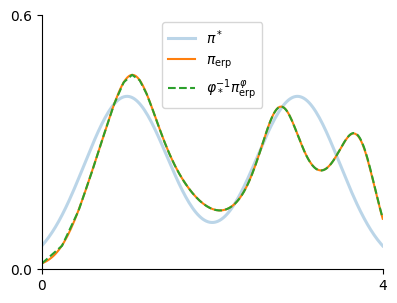

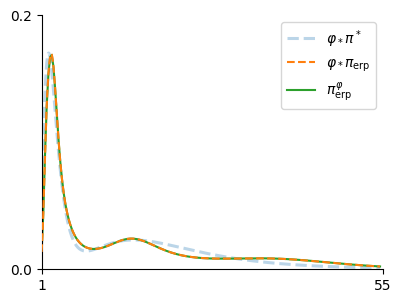

(PyPlot.Figure(PyObject <Figure size 440x330 with 1 Axes>), PyPlot.Figure(PyObject <Figure size 440x330 with 1 Axes>))

In [11]:
wR  = ebprior(m,  d, ReferenceRegularizer(m,  regR), OPTCONFIG)
wRt = ebprior(mt, d, ReferenceRegularizer(mt, regRt), OPTCONFIG)

p1, p2 = compareplot(m, t, pdf.(prior, m.xs), wR, wRt, "erp", lims...; figsize=figsize, savename="eb$randseed")

#plt2mat(p1, "er.mat")
#plt2mat(p2, "erT.mat")

 61.277291 seconds (134.81 M allocations: 325.036 GiB, 18.12% gc time)


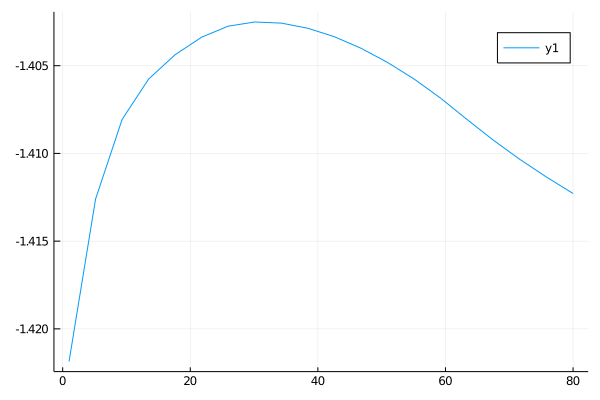

In [12]:
## thik estimator
regs = [ThikonovRegularizer(γ) for γ in linspace(1,80,ncv)]
@time ss = [cvscore(m, d, d->ebprior(m, d, r, OPTCONFIG), kfold) for r in regs]
regT = regs[argmax(ss)].γ
Plots.plot([r.γ for r in regs], ss)


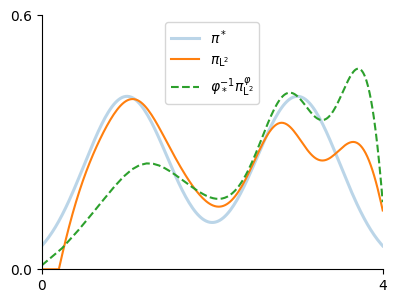

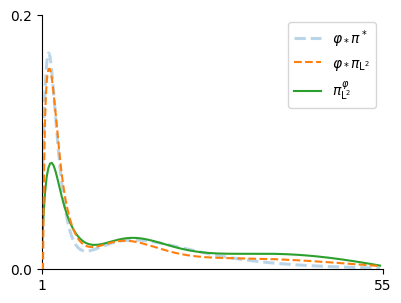

(PyPlot.Figure(PyObject <Figure size 440x330 with 1 Axes>), PyPlot.Figure(PyObject <Figure size 440x330 with 1 Axes>))

In [13]:
wT = ebprior(m,  d, ThikonovRegularizer(regT), OPTCONFIG)
wTto = ebprior(mt, d, ThikonovRegularizer(regT), OPTCONFIG)

p1,p2 = compareplot(m, t, pdf.(prior, m.xs), wT, wTto, "L^2", lims...; figsize=figsize, savename="l2gammafix$randseed")

#plt2mat(p1, "l2.mat")
#plt2mat(p2, "l2T.mat")

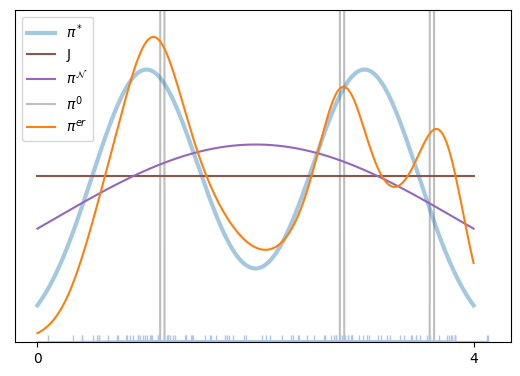

In [14]:
using LinearAlgebra
using PyPlot

w0 = ebprior(m, d, ThikonovRegularizer(0), OptConfig(XTOLABS=1e-30, DEBUG=false);)
w0 = normalize!([(w>0.05) ? 0.001 : 0 for w in w0], 1)
wu = normalize!(ones(length(w0)), 1)

wp = normalize!(pdf.(prior, m.xs), 1)
wn = normalize!(pdf.(Distributions.Normal(2,1.9
            ), m.xs), 1)



w2dens(x) = ObjectiveEmpiricalBayes.weighttodensity(m.xs, x)
scaling = 0.8
PyPlot.figure(figsize=(8*scaling,5.4*scaling))
PyPlot.plot(m.xs, wp|>w2dens, label="\$\\pi^*\$", alpha=.4, linewidth=3)
PyPlot.plot(m.xs,  wu |> w2dens, label = "J", color="#8c564b")
PyPlot.plot(m.xs, wn|> w2dens, label="\$\\pi^\\mathcal{N}\$", color="#9467bd")
PyPlot.plot(m.xs, w0|> w2dens, label="\$\\pi^0\$", zorder=-100, alpha=.5, color="#7f7f7f")
PyPlot.plot(m.xs, wR|> w2dens, label="\$\\pi^{er}\$")
PyPlot.legend()


PyPlot.plot(d, zero(d), marker="2", markersize=10, color="#aec7e8")
PyPlot.ylim(0,0.5)
PyPlot.xticks([0,4])
PyPlot.yticks([])
PyPlot.savefig("all.pdf", bbox_inches="tight")

 44.634909 seconds (131.83 M allocations: 230.717 GiB, 16.60% gc time)


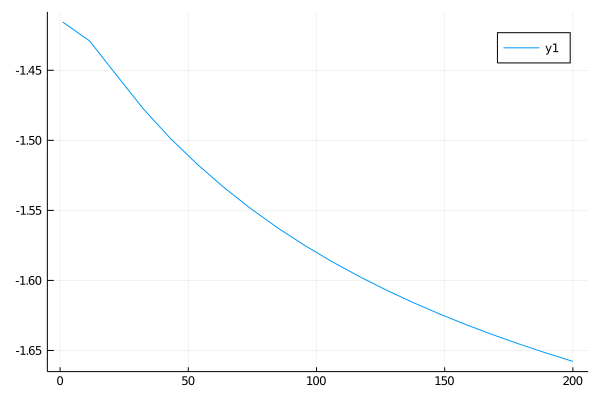

In [15]:
## thik estimator transformed
regs = [ThikonovRegularizer(γ) for γ in linspace(1,200,ncv)]
@time ss = [cvscore(mt, d, d->ebprior(mt, d, r, OPTCONFIG), kfold) for r in regs]
regTt = regs[argmax(ss)].γ
Plots.plot([r.γ for r in regs], ss)


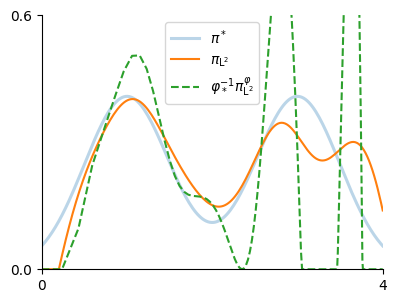

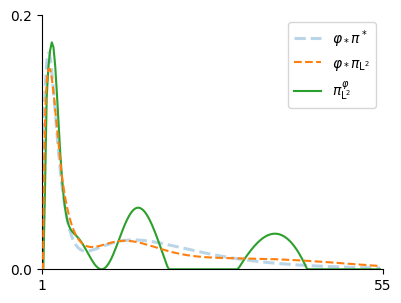

(Figure(PyObject <Figure size 440x330 with 1 Axes>), Figure(PyObject <Figure size 440x330 with 1 Axes>))

In [16]:
wT = ebprior(m,  d, ThikonovRegularizer(regT), OPTCONFIG)
wTt = ebprior(mt, d, ThikonovRegularizer(regTt), OPTCONFIG)

p1, p2 = compareplot(m, t, pdf.(prior, m.xs), wT, wTt, "L^2", lims...; figsize=figsize, savename="l2$randseed")

In [17]:
using MAT
function plt2mat(p, filename)
    d = [(filter(isalpha, l[:get_label]()), hcat(l[:get_data]()...)) for a in p[:axes] for l in a[:lines] ] |> Dict
    matwrite(filename, d)
end

plt2mat (generic function with 1 method)

In [18]:
]add PyCall

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
 Installed Compat ───────── v3.9.0
 Installed DataStructures ─ v0.17.15
  Updating `~/code/empiricalbayes/Project.toml`
  [438e738f] + PyCall v1.91.4
  Updating `~/code/empiricalbayes/Manifest.toml`
  [b99e7846] ↑ BinaryProvider v0.5.8 ⇒ v0.5.9
  [34da2185] ↑ Compat v3.8.0 ⇒ v3.9.0
  [9a962f9c] ↑ DataAPI v1.2.0 ⇒ v1.3.0
  [864edb3b] ↑ DataStructures v0.17.13 ⇒ v0.17.15
  [1a297f60] ↑ FillArrays v0.8.7 ⇒ v0.8.8
  [90137ffa] ↑ StaticArrays v0.12.2 ⇒ v0.12.3
